In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

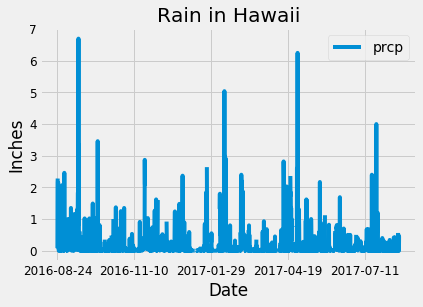

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rain_dates = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(rain_dates, columns=['date','prcp'])
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.title("Rain in Hawaii")
plt.ylabel('Inches')
plt.xlabel('Date')
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.station).first()

('USC00519281', 54.0, 85.0, 71.66378066378067)

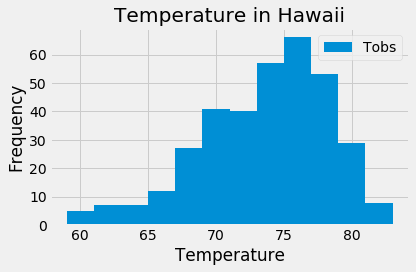

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
bins_list = 12
temps = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= last_year.strftime('%Y-%m-%d')).\
    order_by(Measurement.date).all()
temps = np.ravel(temps)

# Plot Graph
plt.hist(temps, bins=bins_list)
plt.title("Temperature in Hawaii")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.legend(["Tobs"])
plt.tight_layout()

## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
previousyear_start = dt.date(2015, 8, 23)
lastyear_end = dt.date(2016, 8, 23)
previousstart_lastend = calc_temps(previousyear_start, lastyear_end)

trip_temps = [previousstart_lastend[0][0], previousstart_lastend[0][1], previousstart_lastend[0][2]]
print(trip_temps)

[56.0, 74.45063829787235, 86.0]


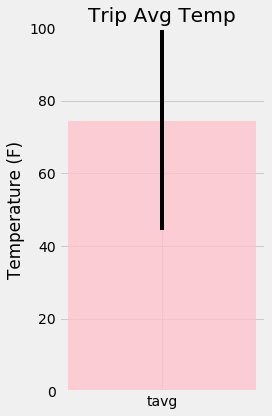

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(4,6))
plt.bar(height=trip_temps[1], x='tavg', width=0.1,yerr=(trip_temps[2]-trip_temps[0]), color='pink', alpha=0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.ylim(0, 100)
plt.tight_layout()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.date >= '2015-08-23').filter(Measurement.date <= '2016-08-23').\
    group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).\
    filter(Measurement.station == Station.station).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  177.98999999999992),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  108.56000000000007),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  72.58999999999999),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  55.580000000000005),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  42.980000000000004),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 23.8),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  4.5600000000000005),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  3.9499999999999997),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.0)]

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
trip_start = '2016-11-01'
trip_end = '2016-11-15'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Stip off the year and save a list of %m-%d strings
monthtrip_dates = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in monthtrip_dates:
    normals.append(daily_normals(date)[0])

normals

[(65.0, 74.86274509803921, 83.0),
 (64.0, 74.0625, 81.0),
 (66.0, 74.95918367346938, 82.0),
 (65.0, 74.0754716981132, 82.0),
 (64.0, 73.5576923076923, 78.0),
 (66.0, 74.31111111111112, 81.0),
 (63.0, 73.76, 80.0),
 (67.0, 73.75, 81.0),
 (67.0, 73.59615384615384, 81.0),
 (63.0, 72.47916666666667, 79.0),
 (67.0, 74.3913043478261, 80.0),
 (62.0, 72.78, 80.0),
 (61.0, 72.48979591836735, 79.0),
 (68.0, 74.33333333333333, 80.0),
 (65.0, 73.67924528301887, 79.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_weather = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_weather['date'] = trip_dates
trip_weather.set_index(['date'], inplace=True)
trip_weather

,tmin,tavg,tmax
date,,,
2016-11-01,65.0,74.862745,83.0
2016-11-02,64.0,74.062500,81.0
2016-11-03,66.0,74.959184,82.0
2016-11-04,65.0,74.075472,82.0
2016-11-05,64.0,73.557692,78.0
2016-11-06,66.0,74.311111,81.0
2016-11-07,63.0,73.760000,80.0
2016-11-08,67.0,73.750000,81.0
2016-11-09,67.0,73.596154,81.0


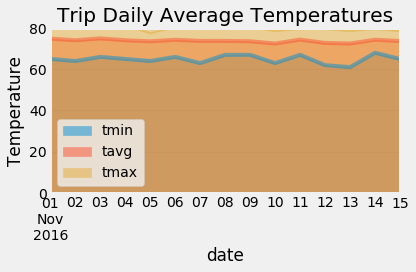

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
Hawaii_daily_normals_df=pd.date_range(start='2016/11/01', end='2016/11/15', freq='M')
ax = trip_weather.plot.area(stacked=False)
plt.title("Trip Daily Average Temperatures")
plt.ylabel("Temperature")
plt.ylim(0,80)
plt.tight_layout()